# Image Captioning with Attention

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image
from tensorflow.keras.preprocessing.text import Tokenizer

import itertools

tf.random.set_seed(1)

Loading the Data. The data consist of pictures and labels of linear functions

In [2]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
folder="../../linear_fcns/images"

In [3]:
images = load_images_from_folder(folder)

In [4]:
labels = pd.read_csv('../../linear_fcns/data.csv')

In [5]:
label_array = labels['latex'].to_numpy()
labels_mini = label_array[:6000]

For the labels we need to add start and end tokens so the model can recognize what to write.

In [6]:
for val in range(len(labels_mini)):
    labels_mini[val] = f'<start> {labels_mini[val]} <end>'

Let's reshape the images so we can plot them.

In [7]:
images_mini = images[:6000]
images_mini = np.array(images_mini)
images_mini = 255 - images_mini
images_mini = tf.image.rgb_to_grayscale(images_mini)
images_mini = np.array(images_mini)
images_mini.shape

(6000, 72, 360, 1)

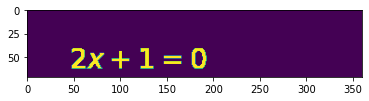

In [8]:
plt.imshow(images_mini[0])

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [9]:
img_mini = tf.image.resize_with_pad(images_mini, 299, 299)

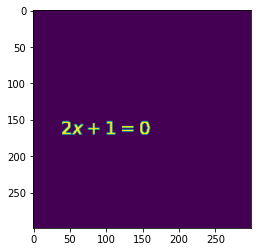

In [10]:
plt.imshow(img_mini[0])

In [20]:
X_train = img_mini[:4000]
y_train = labels_mini[:4000]
X_test = img_mini[4000:]
y_test = labels_mini[4000:]

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [29]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [30]:
# Choose the top 5000 words from the vocabulary
train_seqs = tokenizer.texts_to_sequences(labels_mini)

NameError: name 'tokenizer' is not defined

In [31]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

NameError: name 'tokenizer' is not defined

In [87]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(labels_mini)

In [88]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [89]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

Now we can begin our function to build our CNN. We do this to be able to run the CNN multiple times with different parameters.

In [32]:
def build_model(conv_layers, pool_layers, epochs, X_train, y_train, X_test, y_test, layer_map):
    cnn_model = build_cnn(conv_layers, pool_layers)



      # Define a loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

      # Compile the model
    cnn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.3)

      #plot_history(history, epochs)

      #confusionmatrix(model= cnn_model)

    filters(model=cnn_model, X_test= X_test, y_test=y_test, layer_map=layer_map)

    return history

This builds the actual CNN.

In [33]:
def build_cnn(conv_layers, pool_layers):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(30, kernel_size=5,activation='linear',input_shape=(299,299,1),padding='same'))
    model_cnn.add(MaxPooling2D((5, 5), padding='same'))
    model_cnn.add(Dropout(0.4))
    x=15
    for i in range(1, conv_layers):
        if i <= conv_layers-1:        
            model_cnn.add(Conv2D(x, kernel_size=5,activation='linear',padding='same'))
            model_cnn.add(MaxPooling2D((5, 5), padding='same'))
            model_cnn.add(Dropout(0.4))
            x=x


    print(model_cnn.summary())
    return model_cnn

This will plot our accuracy for analysis.

In [34]:
def plot_history(history, epochs):
    epochs = range(epochs)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, train_acc, color='blue', label='Training accuracy') 
    plt.plot(epochs, val_acc, color='red', label='Validation accuracy')
    plt.legend()
    plt.grid()

In [35]:
def confusionmatrix(model):

    confusion = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1))

    confusion_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

    classes=[0,1,2,3,4,5,6,7,8,9]

    plt.figure(figsize=(14,14))
    plt.imshow(confusion_norm, interpolation='nearest') 
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    fmt = '.2f'
    thresh = confusion_norm.max() / 2.
    for i, j in itertools.product(range(confusion_norm.shape[0]), range(confusion_norm.shape[1])):
        plt.text(j, i, format(confusion_norm[i, j], fmt), horizontalalignment="center",
        color="black" if confusion_norm[i, j] > thresh else "white")
    plt.tight_layout()

In [36]:
def filters(model, X_test, y_test, layer_map):
  # redefine model to output right after the first hidden layer
    model = Model(inputs=model.inputs, outputs=model.layers[layer_map].output)
    model.summary()
      # get feature map for first hidden layer
    feature_maps = model.predict(X_test[0].reshape(1,28,28,1))

    height=8
    width=4
    ix = 1
    plt.figure(figsize=(14,14))
    for _ in range(width):
        for _ in range(height):
            ax = plt.subplot(height, width, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
            ix += 1
      # show the figure
    plt.show()

In [37]:
build_model(conv_layers=2, pool_layers=2, epochs=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, layer_map=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 299, 299, 30)      780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 30)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 15)        11265     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 15)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 15)        0         
Total params: 12,045
Trainable params: 12,045
Non-trainable params: 0
__________________________________________________

UnimplementedError:  Cast string to float is not supported
	 [[node sparse_categorical_crossentropy/Cast (defined at <ipython-input-32-a37d83c6d059>:12) ]] [Op:__inference_train_function_1677]

Function call stack:
train_function
